In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.gridspec import GridSpec
from scipy.signal import butter, filtfilt

from mtj.init import init_m
from mtj.llg_heun import LLG_Heun
from mtj.constants import VACUUM_PERMEABILITY
from mtj.types import MaterialProps

## Type of MTJ: In-Plane vs. Perpendicular

Device which is simulated is the magnetization dynamics of an in-plane free layer of a magnetic tunnel junction (MTJ), subject to thermal fluctuations at room temperature, with no external applied field, typical nanoscale volume, and damping.

In [2]:
def calculate_magnetization(
    m0: npt.NDArray[
        np.float64
    ],  # Initial magnetization (is normalized before simulation)
    H_app: npt.NDArray[np.float64],
    Tn=1e-10,  # (s)
    dt=1e-13,  # time step (s)
    alpha=0.01,  # Damping factor (arbitrarily chosen in this demo)
    u_k = np.array([0, 0, 1]),  # Perpendicular MCA
    K_u = 2e3,
    M_s=1 / VACUUM_PERMEABILITY,  # Default: NiFe permalloy Ms (A/m)
    N=np.diag([0.029569, 0.029569, 0.940862]),  # Default: "infinite" thin film
    T=300,
    Vol=1e-9 * 25e-9**2 * np.pi,  # Volume
    Volt=0,  # STT voltage
    p=np.array([0, 0, 1]),  # STT polarizer orientation
    a_par=0,  # STT coefficients
    a_perp=0,
    stt_enable=False,
    recompute_H_th=True,
    recompute_H_eff=False,
):
    time_series = np.arange(0, Tn, dt)
    m = init_m(m0, len(time_series))
    params: MaterialProps = {
        "K_u": K_u,
        "M_s": M_s,
        "u_k": u_k,
        "p": p,
        "a_para": a_par,
        "a_ortho": a_perp,
        "V": Volt,
        "H_app": 0,
        "N": N,
    }

    for i, t in enumerate(time_series[:-1]):
        # Calculate the magnetization for the next time step
        m[i + 1] = LLG_Heun(
            m[i],
            T,
            Vol,
            dt,
            alpha,
            stt_enable=stt_enable,
            recompute_H_th=recompute_H_th,
            recompute_H_eff=recompute_H_eff,
            **params,
        )

    return m, time_series

## Overview for New Users

This code simulates the magnetization dynamics of a Magnetic Tunnel Junction (MTJ) device under an oscillating magnetic field and calculates the corresponding resistance and voltage responses. It is designed to analyze the switching behavior between low and high resistance states.

### Key Concepts

- **Magnetization Dynamics:** The magnetization vector *m(t)* evolves over time under a sinusoidal magnetic field.
- **Resistance Calculation:** Resistance depends on the alignment between *m(t)* and a fixed polarization vector, modeled with a simplified conductance formula.
- **Driving Current:** A combination of DC and AC current drives the device, generating a voltage signal *V(t) = I(t) × R(t)*.
- **Dwell Time Extraction:** The code identifies state transitions by thresholding resistance values and calculates how long the device remains in each state (dwell times).
- **Visualization:** Histograms of dwell times provide insights into the stability and switching dynamics of the device.

### Important Parameters and Typical Values

| Parameter              | Symbol        | Typical Value             | Description                         |
|------------------------|---------------|---------------------------|-----------------------------------|
| Time step              | $dt$          | $1 \times 10^{-9}$ s      | Simulation timestep                |
| Total simulation time  | $T_n$         | $5 \times 10^{-6}$ s      | Duration of the simulation         |
| Damping factor         | $\alpha$      | 0.001                     | Magnetic damping parameter         |
| Temperature            | $T$           | 1000 K                    | Simulation temperature             |
| Volume                 | $V$           | $1 \times 10^{-9} \times (2 \times 10^{-9})^2 \pi$ m³ | Magnetic volume                   |
| Applied field amplitude| $H_{amp}$     | $2 \times 10^{6}$ A/m     | Amplitude of oscillating field     |
| Field frequency        | $f_H$         | 2 GHz                     | Frequency of oscillating field     |
| Parallel resistance    | $R_P$         | 2000 Ω                    | Resistance in low resistance state |
| Antiparallel resistance| $R_{AP}$      | 500 Ω                     | Resistance in high resistance state|
| DC current             | $I_{dc}$      | 10 μA                     | DC component of driving current    |
| AC current amplitude   | $A_{ac}$      | 3 μA                      | Amplitude of AC current injection  |
| AC current frequency   | $f_{ext}$     | 10 MHz                    | Frequency of AC current injection  |

Feel free to adjust these parameters to explore different device behaviors. The modular structure of the code makes it easy to extend for further analysis or custom scenarios.

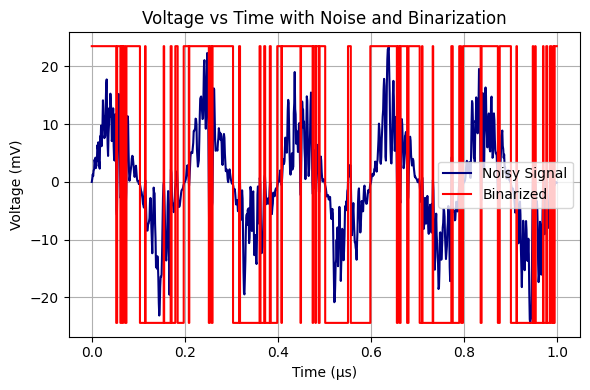

In [3]:
from scipy.signal import butter, filtfilt
dt = 1e-9  # 1 ns timestep
f0 = 5e6
Tn = 5e-6
H_amp = 20e5  # Amplitude of the field in A/m
f_H = 2e9    # Oscillation frequency in Hz (e.g., 2 GHz)
ts = np.arange(0, Tn, dt)  # Same shape as inside calculate_magnetization

# Oscillating field in z-direction
H_app = np.column_stack([
    np.zeros_like(ts),  # Hx = 0
    np.zeros_like(ts),  # Hy = 0
    H_amp * np.sin(2 * np.pi * f_H * ts)  # Hz(t)
])

m_array, ts = calculate_magnetization(
    m0=np.array([0, 0, 1]),
    H_app=0,
    Tn=Tn,
    dt=dt,
    alpha=0.001,
    T=1000,
    Vol=1e-9 * 2e-9**2 * np.pi,
    stt_enable=False,
)

# Resistance function (simplified)
def magnetization_to_resistance(m_array, R_P=2000, R_AP=500, p=np.array([0, 0, 1])):
    G_0 = 1 / R_P
    G_180 = 1 / R_AP
    ΔG = G_0 - G_180
    G_90 = (G_0 + G_180) / 2
    dot_product = m_array @ p
    G_series = G_90 + 0.5 * ΔG * dot_product
    R_series = 1 / G_series
    return R_series

R_series = magnetization_to_resistance(m_array)

# Currents as before
I_dc = 10e-6
f_ext = 2 * f0
A_ac = 3e-6
I_ac_injection = A_ac * np.sin(2 * np.pi * f_ext * ts)
I_total = I_dc + I_ac_injection

# Voltage signal
V_series = I_total * R_series
def generate_switching_signal(length, low_val, high_val, mean_dwell=100):
    signal = np.zeros(length)
    current_state = 0
    count = 0
    dwell = np.random.poisson(mean_dwell)
    for i in range(length):
        signal[i] = low_val if current_state == 0 else high_val
        count += 1
        if count > dwell:
            current_state = 1 - current_state  # toggle state
            count = 0
            dwell = np.random.poisson(mean_dwell)
    return signal

noise_amplitude = 10e-3

def lowpass_filter(signal, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Generate white noise
raw_noise = np.random.normal(0, noise_amplitude, size=V_series.shape)

# Filtered noise with a cutoff of 1 GHz (adjust as needed)
fs = 1/dt  # Sampling frequency in Hz
filtered_noise = lowpass_filter(raw_noise, cutoff=200e6, fs=fs)
V_noisy = V_series + filtered_noise

# Mix with reference signal and low-pass filter (same as original)
reference_signal = np.sin(2 * np.pi * f_ext / 2 * ts)
mixed_signal = V_noisy * reference_signal

window_size = max(1, int(1e-9 / dt))  # e.g., 1 ns window or less
mixed_signal_lp = np.convolve(mixed_signal, np.ones(window_size)/window_size, mode='same')

V_to_plot = mixed_signal_lp * 1e3  # in mV

# Zoom window (0.1 us)
mask = ts <= 1e-6
time_window = ts[mask]
voltage_window = V_to_plot[mask]

# Threshold for binarization
v_low = np.min(voltage_window)
v_high = np.max(voltage_window)
v_thresh = (v_high + v_low) / 2
binary_voltage = np.where(voltage_window > v_thresh, v_high, v_low)

# Plot 1: Voltage vs Time with binarization and noise
plt.figure(figsize=(6, 4))
plt.plot(time_window * 1e6, voltage_window, label="Noisy Signal", color='navy')
plt.step(time_window * 1e6, binary_voltage, label="Binarized", color='red', where='mid')
plt.title("Voltage vs Time with Noise and Binarization")
plt.xlabel("Time (µs)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Dwell Time Analysis for Magnetoresistance Switching

This code extracts and visualizes the dwell times—durations spent in low-resistance (P) and high-resistance (AP) states—from a simulated magnetization-driven resistance time series.

Key Parameters:
- R_P (float): Resistance value for the Parallel (P) magnetic state. Typical value: 2000 Ω
- R_AP (float): Resistance value for the Anti-Parallel (AP) magnetic state. Typical value: 500 Ω
- threshold (float): Resistance threshold to classify states (midpoint of R_P and R_AP, i.e., 1250 Ω)
- dt (float): Time step used in the simulation (defines time resolution). Example: 1e-9 s (1 ns)
- m_array (np.array): Array of magnetization vectors over time (output from magnetization simulation)
- ts (np.array): Corresponding time stamps for each magnetization sample, usually uniformly spaced by dt

The magnetization is converted to resistance using a simplified model that maps the dot product of the magnetization and polarization vectors to resistance.

The dwell times are calculated by detecting transitions in resistance states crossing the threshold. Histograms of dwell times for both states are plotted to analyze the stability and switching dynamics.

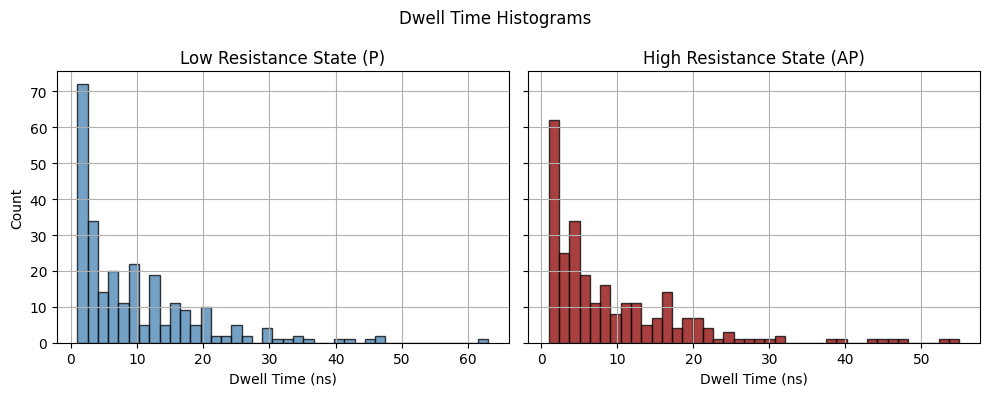

--- Events ---
  P state events:  263
  AP state events: 263


In [5]:
dt = 1e-9  # timestep
Tn = 5e-6  # total time
H_app = np.zeros((int(Tn/dt), 3))  # no external field for simplicity

# --- Convert magnetization to resistance ---
def magnetization_to_resistance(m_array, R_P, R_AP, p_vector):
    cos_theta = np.dot(m_array, p_vector)  # m·p (vector dot product over axis 1)
    return R_P + (R_AP - R_P) * (1 - cos_theta) / 2  # Resistance model

def extract_dwell_times(mz, ts, threshold):
    """
    Extracts dwell times for two-state resistance signal,
    ensuring only positive-duration dwell periods are included.
    """
    states = (mz < 0).astype(int)  # 0 = P, 1 = AP
    dwell_times = []
    current_state = states[0]
    start_time = ts[0]

    for i in range(1, len(states)):
        if states[i] != current_state:
            end_time = ts[i]
            dwell_duration = end_time - start_time
            if dwell_duration > 0:  # Keep only valid (positive) durations
                dwell_times.append((current_state, dwell_duration))
            current_state = states[i]
            start_time = ts[i]  # reset start time

    # Add final dwell time if positive
    final_duration = ts[-1] - start_time
    if final_duration > 0:
        dwell_times.append((current_state, final_duration))

    return dwell_times

# --- Plot histogram of dwell times ---
def plot_dwell_histograms(dwell_times, dt_unit='ns'):
    dwell_0 = [dt for s, dt in dwell_times if s == 0]  # P state
    dwell_1 = [dt for s, dt in dwell_times if s == 1]  # AP state

    if dt_unit == 'ns':
        dwell_0 = [x * 1e9 for x in dwell_0]
        dwell_1 = [x * 1e9 for x in dwell_1]
        unit_label = 'Dwell Time (ns)'
    else:
        unit_label = 'Dwell Time (s)'

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    axs[0].hist(dwell_0, bins=40, color='steelblue', edgecolor='black', alpha=0.75)
    axs[0].set_title("Low Resistance State (P)")
    axs[0].set_xlabel(unit_label)
    axs[0].set_ylabel("Count")
    axs[0].grid(True)

    axs[1].hist(dwell_1, bins=40, color='darkred', edgecolor='black', alpha=0.75)
    axs[1].set_title("High Resistance State (AP)")
    axs[1].set_xlabel(unit_label)
    axs[1].grid(True)

    plt.suptitle("Dwell Time Histograms")
    plt.tight_layout()
    plt.show()

    print(f"--- Events ---")
    print(f"  P state events:  {len(dwell_0)}")
    print(f"  AP state events: {len(dwell_1)}")

m_array, ts = calculate_magnetization(
    m0=np.array([0, 0, 1]),
    H_app=H_app,
    Tn=Tn,
    dt=dt,
    alpha=0.01,
    T=1000,
    Vol=1e-9 * 2e-9**2 * np.pi,
    stt_enable=False,
)

m_z = m_array[:, 2]  # z-component not needed here since we use full m_array

# Resistance function (simplified)
def magnetization_to_resistance(m_array, R_P=2000, R_AP=500, p=np.array([0, 0, 1])):
    p = p / np.linalg.norm(p)  # normalize p vector
    G_0 = 1 / R_P
    G_180 = 1 / R_AP
    ΔG = G_0 - G_180
    G_90 = (G_0 + G_180) / 2
    dot_product = m_array @ p  # shape (N,)
    G_series = G_90 + 0.5 * ΔG * dot_product
    R_series = 1 / G_series
    return R_series

# Make sure R_P and R_AP are defined:
R_P = 2000
R_AP = 500

R_series = magnetization_to_resistance(m_array, R_P=R_P, R_AP=R_AP)

threshold = (R_P + R_AP) / 2

dwell_times = extract_dwell_times(m_z, ts, threshold)
plot_dwell_histograms(dwell_times)
